In [59]:
import scipy.io as scio
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from tqdm.notebook import tqdm
import os
import random
from skimage.segmentation import slic,felzenszwalb
from IPython import display
from libtiff import TIFF
from Performance import performance
import torch

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [60]:
def data_norm(data):
    mean = torch.mean(data)
    std = torch.std(data)
    data = (data - mean)/std
    return data

def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.reshape(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

### Get normlized data and ground truth 

The number of classes is: 16


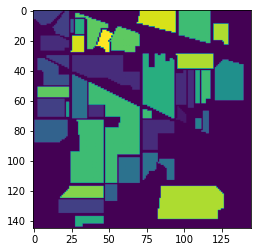

In [61]:
path = '../Data/Indian_Pines/Indian_pines_corrected.mat'
data = scio.loadmat(path)
data = data['indian_pines_corrected']
data_ = torch.FloatTensor(data.astype(float))
data = data_norm(data_)

path = '../Data/Indian_Pines/Indian_pines_gt.mat'
ground_turth = scio.loadmat(path)
ground_turth = ground_turth['indian_pines_gt']
ground_turth = torch.FloatTensor(ground_turth.astype(int))

data_width = data.shape[0]
data_height = data.shape[1]
channel_num = data.shape[2]

plt.imshow(ground_turth)
class_num = len(set(np.array(ground_turth.reshape(-1))))-1
print('The number of classes is:', class_num)

In [62]:
from collections import Counter

Number_class = Counter(list(np.array(ground_turth.reshape(-1))))
count = np.zeros(class_num+1)
count[np.array(list(Number_class.keys())).astype(int)] = list(Number_class.values())
count = count[1:]

# train_count = np.zeros(class_num)
# train_count[np.where(count>30)] = 30
# # train_count[np.where(count<=50)] = 30
# train_count[np.where(count<=30)] = 15

# train_count[np.where(count>150)] = 30
# train_count[np.where(count<=50)] = 30
# train_count[np.where(count<=30)] = 15

# train_count = list(train_count.astype(int))
train_count = list(np.around(count*0.15).astype(int))
train_count

[7, 214, 124, 36, 72, 110, 4, 72, 3, 146, 368, 89, 31, 190, 58, 14]

In [63]:
# size = (35,35)

# data = nn.UpsamplingNearest2d(size=size)(data.permute(2,0,1).unsqueeze(0))[0].permute(1,2,0)
# ground_turth = nn.UpsamplingNearest2d(size=size)(ground_turth.unsqueeze(0).unsqueeze(0))[0,0]
# data_ = nn.UpsamplingNearest2d(size=size)(data_.permute(2,0,1).unsqueeze(0))[0].permute(1,2,0)

# data_width = data.shape[0]
# data_height = data.shape[1]
# channel_num = data.shape[2]

# plt.imshow(ground_turth)
# class_num = len(set(np.array(ground_turth.reshape(-1))))-1
# print('The number of classes is:', class_num)

### Type (混用): Getting train and test mask

The match between train_count and train_class:  True


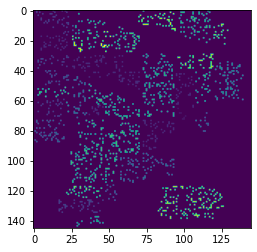

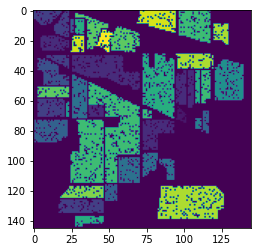

In [64]:
# Get class's position index
classes_index = []
for i in range(class_num+1): #with the background
    class_index = np.argwhere(np.array(ground_turth) == i)
    np.random.shuffle(class_index)
    classes_index.append(class_index)

# Get train and test index for each class
# train_count = [30,30,30,30,30,30,15,30,15,30,30,30,30,30,30,30]

test_count = []
print('The match between train_count and train_class: ', len(train_count) == class_num)

train_index = []
test_index = []
for i in range(class_num):
    train_index.append(classes_index[i+1][:train_count[i]])
    test_index.append(classes_index[i+1][-(len(classes_index[i+1])-train_count[i]):])
    test_count.append(len(classes_index[i+1])-train_count[i])
# Get train and test mask
train_mask = torch.zeros(data.shape[:2])
test_mask = torch.zeros(data.shape[:2])
for i in range(class_num):
    train_mask[train_index[i][:,0],train_index[i][:,1]] = 1
    test_mask[test_index[i][:,0],test_index[i][:,1]] = 1
plt.imshow(train_mask * ground_turth)
plt.show()
plt.imshow(test_mask * ground_turth)
plt.show()

In [65]:
print('Train count:',train_count)
print('Test count:',test_count)

Train count: [7, 214, 124, 36, 72, 110, 4, 72, 3, 146, 368, 89, 31, 190, 58, 14]
Test count: [39, 1214, 706, 201, 411, 620, 24, 406, 17, 826, 2087, 504, 174, 1075, 328, 79]


### Get SLIC segmentation

Block_num: 18


/home/amax/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  """Entry point for launching an IPython kernel.


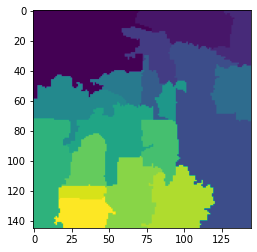

In [66]:
seg_index = (slic(np.array(data_), n_segments=50, max_iter=2))
# seg_index = felzenszwalb(np.array(data), scale=100, sigma=0.5, min_size=100)
# seg_index = torch.arange(data_width*data_height).reshape(data_width, data_height).numpy()

seg_index = torch.Tensor(seg_index.copy())
# seg_index = ground_turth
Block_num = len(set(np.array(seg_index.reshape(-1))))
print('Block_num:', Block_num)
plt.imshow(seg_index)

### Adj_mask computation

In [67]:
#Fully connection
adj_mask = torch.ones(Block_num,Block_num).int().cuda()

In [68]:
#K-neighbour
# adj_mask = torch.zeros(Block_num,Block_num).int()
# for row in tqdm(range(seg_index.shape[0])):
#     for low in range(seg_index.shape[1]):
#         block_ids = list(set(np.array(seg_index[row-1:row+2, low-1:low+2].reshape(-1)).astype(int)))
#         adj_mask[seg_index[row,low].long(),block_ids] = int(1)
# plt.imshow(adj_mask)
# adj_mask = adj_mask.cuda()

# Train

In [69]:
# Net = SegNet(in_channel = channel_num, block_num = Block_num,class_num=class_num+1, adj_mask = adj_mask).cuda()
# root = 'work_dir_Indian/'
# Net.load_state_dict(torch.load(root+'best_kappa.pth'))
# hsimg = data.permute(2,0,1).unsqueeze(0).cuda()
# classes = Net(hsimg,seg_index.unsqueeze(0).unsqueeze(0)).cpu().detach()
# plt.figure(dpi = 300)
# plt.imsave(root+'indian.png',torch.max(torch.softmax(classes[0], dim =0),dim = 0)[1].cpu()*(ground_turth>0).float())

In [70]:
# train_mask = torch.Tensor(np.load('work_dir_Indian/train_mask.npy'))
# test_mask = torch.Tensor(np.load('work_dir_Indian/test_mask.npy'))

In [71]:
# from Model import SegNet

In [72]:
from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter
import math
import torch.nn as nn
import torch
from torch.nn import init
class Graph2dConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(
        self,
        in_channels,
        out_channels,
        block_num,
        adj_mask = None,
        if_feature_update = True,
        for_classification = False
    ):
        super(Graph2dConvolution, self).__init__()
        
        self.weight = Parameter(torch.randn(in_channels, out_channels))
        self.W = Parameter(torch.randn(out_channels, out_channels))
        self.bn = nn.BatchNorm2d(out_channels)
        
        self.reset_parameters()
        
        self.in_features = in_channels
        self.out_features = out_channels
        self.block_num = block_num
        self.adj_mask = adj_mask
        self.if_feature_update = if_feature_update
        self.for_classification = for_classification
        
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        init.kaiming_uniform_(self.W, a=math.sqrt(5))

    def forward(self, input, index):
        input = (input.permute(0,2,3,1)).matmul(self.weight).permute(0,3,1,2)
        
        if self.if_feature_update:
            index = nn.UpsamplingNearest2d(size = (input.shape[2],input.shape[3]))(index.float()).long()
            batch_size = input.shape[0]
            channels = input.shape[1]

            # get one-hot label
            index_ex = torch.zeros(batch_size,self.block_num,input.shape[2],input.shape[3]).cuda()
            index_ex = index_ex.scatter_(1, index, 1)
            block_value_sum = torch.sum(index_ex,dim = (2,3))

            # computing the regional mean of input
            input_ = input.repeat(self.block_num,1,1,1,1).permute(1,0,2,3,4)
            index_ex = index_ex.unsqueeze(2)
            input_means = torch.sum(index_ex * input_,dim = (3,4))/(block_value_sum+(block_value_sum==0).float()).unsqueeze(2) #* mask.unsqueeze(2)

            # computing the adjance metrix
            input_means_ = input_means.repeat(self.block_num, 1, 1, 1).permute(1, 2, 0, 3)
            input_means_ = (input_means_ - input_means.unsqueeze(1)).permute(0, 2, 1, 3)
            M = (self.W).mm(self.W.T)
            adj = input_means_.reshape(batch_size, -1, channels).matmul(M)
            adj = torch.sum(adj * input_means_.reshape(batch_size, -1, channels),dim=2).view(batch_size, self.block_num,self.block_num)
            adj = torch.exp(-1 * adj)+ torch.eye(self.block_num).repeat(batch_size, 1, 1).cuda()
            if self.adj_mask is not None:
                adj = adj * self.adj_mask

            # generating the adj_mean
            adj_means = input_means.repeat(self.block_num,1,1,1).permute(1,0,2,3) * adj.unsqueeze(3)
            adj_means = (1-torch.eye(self.block_num).reshape(1,self.block_num,self.block_num,1).cuda()) * adj_means
            adj_means = torch.sum(adj_means, dim=2) # batch_size，self.block_num, channel_num

            #obtaining the graph update features
            features = torch.sum(index_ex * (input_ + adj_means.unsqueeze(3).unsqueeze(4)),dim=1)
#             features = data_norm(features)
            features = self.bn(features) 

#             if self.for_classification==False:
#                 features = self.bn(features) #for normlizing data
        else:
            features = input
            features = self.bn(features)
        return features

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'
               
class SegNet(nn.Module):
    def __init__(self, in_channel, block_num, class_num, adj_mask = None, if_feature_update=True, scale_layer=4):
        super(SegNet, self).__init__()
        print('2D Graph convolution network are contructing~~~')

        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.gcn1 = Graph2dConvolution(in_channel,in_channel,block_num = block_num, adj_mask = adj_mask, if_feature_update=if_feature_update)

        self.gcn2 = Graph2dConvolution(in_channel,in_channel,block_num = block_num, adj_mask = adj_mask, if_feature_update=if_feature_update)

        self.gcn3 = Graph2dConvolution(in_channel,in_channel,block_num = block_num, adj_mask = adj_mask, if_feature_update=if_feature_update)

        self.gcn4 = Graph2dConvolution(in_channel,in_channel,block_num = block_num, adj_mask = adj_mask, if_feature_update=if_feature_update)

        self.gcn = Graph2dConvolution(int(in_channel*scale_layer),class_num,block_num = block_num, adj_mask = adj_mask, if_feature_update=if_feature_update,for_classification = True)
        
        self.block_num = block_num
        self.Softmax = nn.Softmax(dim = 1)
        self.scale_layer = scale_layer
    def forward(self,hsimg,seg_index):
        Up = nn.UpsamplingBilinear2d(size = (hsimg.shape[2],hsimg.shape[3]))

        index = seg_index.long().cuda()
        
        if self.scale_layer >= 1:
            f1 = self.gcn1(hsimg,index)
            f1_ = self.maxpool(f1)
            f1 = Up(f1_)
            
        if self.scale_layer >= 2:
            f2 = self.gcn2(f1_,index)
            f2_ = self.maxpool(f2)
            f2 = Up(f2_)
            
        if self.scale_layer >= 3:
            f3 = self.gcn3(f2_,index)
            f3_ = self.maxpool(f3)
            f3 = Up(f3_)
            
        if self.scale_layer >= 4:
            f4 = self.gcn4(f3_,index)
            f4_ = self.maxpool(f4)
            f4 = Up(f4_)
            
        if self.scale_layer==1:
            final_class = self.gcn(f1,index)
        if self.scale_layer==2:
            final_class = self.gcn(torch.cat((f1,f2),dim=1),index)
        if self.scale_layer==3:
            final_class = self.gcn(torch.cat((f1,f2,f3),dim=1),index)
        if self.scale_layer==4:
            final_class = self.gcn(torch.cat((f1,f2,f3,f4),dim=1),index)
        return final_class

In [73]:
def train_and_test():
    Net = SegNet(in_channel = channel_num, 
                         block_num = Block_num,
                         class_num=class_num+1, 
                         adj_mask = adj_mask,
                         if_feature_update = if_up,
                         scale_layer = scale).cuda()
    # Net.load_state_dict(torch.load('best.pth'))

    #Loss
    lossf = nn.CrossEntropyLoss()

    EPOCHS = 2500
    FOUND_LR = 1e-3
    opt = torch.optim.Adam(Net.parameters(), lr = FOUND_LR)

    scheduler = lr_scheduler.StepLR(opt, step_size=500, gamma=0.6)


    best_kappa = 0
    losses = []

    hsimg = data.permute(2,0,1).unsqueeze(0).cuda()
    for epoch in tqdm(range(EPOCHS)):
#         Net.train()
        classes = Net(hsimg,seg_index.unsqueeze(0).unsqueeze(0))
        train_gt = ground_turth * train_mask
        pre_gt = torch.cat((train_gt.unsqueeze(0).cuda(),classes[0]),dim=0).view(class_num+2,-1).permute(1,0)
        pre_gt_ = pre_gt[torch.argsort(pre_gt[:,0],descending=True)]
        pre_gt_ = pre_gt_[:int(train_sum)]
        loss = lossf(pre_gt_[:,1:],pre_gt_[:,0].long())
        losses.append(float(loss))

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()
        if (epoch+1) % 5 == 0: 
#             Net.eval()
            classes = Net(hsimg,seg_index.unsqueeze(0).unsqueeze(0)).cpu().detach()
            test_gt = ground_turth * test_mask
            pre_gt = torch.cat((test_gt.unsqueeze(0),classes[0]),dim=0).view(class_num+2,-1).permute(1,0)
            pre_gt_ = pre_gt[torch.argsort(pre_gt[:,0],descending=True)]
            pre_gt_ = pre_gt_[:int(test_sum)]

            OA, AA, kappa, ac_list = performance(pre_gt_[:,1:],pre_gt_[:,0].long(),class_num)

            if best_kappa<kappa:
                best_kappa = kappa
                best_OA = OA
                best_AA = AA
                best_list = ac_list

                torch.save(Net.state_dict(), 'work_dir_Indian/best_kappa.pth')
                plt.imshow(torch.max(torch.softmax(classes[0], dim =0),dim = 0)[1].cpu()*(ground_turth>0).float())
                display.clear_output(wait=True)
                plt.show()
                print('epoch',epoch,':','OA:',OA,'AA:',AA,'KAPPA:',kappa)
                print('epoch',epoch,':','Accuracy_list:',ac_list)

        if (epoch+1) % 100 == 0:          
            losses = []
            
    return best_kappa, best_OA, best_AA, best_list

In [ ]:
train_sum = torch.sum(train_mask)
test_sum = torch.sum(test_mask)

best_kappas = []
best_OAs = []
best_AAs = []
best_lists = []

list_best_OAs_mean = []
list_best_AAs_mean = []
list_best_kappas_mean = []

list_best_OAs_std = []
list_best_AAs_std = []
list_best_kappas_std = []

# scale_list = [4,3,2,1]
# feature_up_list = [True, False]

scale_list = [4]
feature_up_list = [True]

for scale in scale_list:
    for if_up in feature_up_list:
        for i in range(10):
            #Model
            best_kappa, best_OA, best_AA, best_list = train_and_test()
            best_kappas.append(best_kappa)
            best_OAs.append(best_OA)
            best_AAs.append(best_AA)
            best_lists.append(best_list)


        list_best_OAs_mean.append(np.mean(best_OAs))
        list_best_AAs_mean.append(np.mean(best_AAs))
        list_best_kappas_mean.append(np.mean(best_kappas))

        list_best_OAs_std.append(np.std(best_OAs))
        list_best_AAs_std.append(np.std(best_AAs))
        list_best_kappas_std.append(np.std(best_kappas))

        # print('OA:',np.mean(best_OAs),'+-',np.std(best_OAs))
        # print('AA:',np.mean(best_AAs),'+-',np.std(best_AAs))
        # print('kappa:',np.mean(best_kappas),'+-',np.std(best_kappas))
        # print('list:',np.mean(np.array(best_lists),axis=0),'+-',np.std(np.array(best_lists),axis=0))

In [76]:
# %15
print('OA:',np.mean(best_OAs),'+-',np.std(best_OAs))
print('AA:',np.mean(best_AAs),'+-',np.std(best_AAs))
print('kappa:',np.mean(best_kappas),'+-',np.std(best_kappas))
print('list:',np.mean(np.array(best_lists),axis=0),'+-',np.std(np.array(best_lists),axis=0))

OA: 0.9943290092985879 +- 0.000702424912904498
AA: 0.994955 +- 0.0006838471137615434
kappa: 0.9935350299965142 +- 0.0008007461329981173
list: [1.      0.98566 0.99122 1.      0.98686 0.99582 1.      1.      1.
 0.99976 0.99502 0.99286 0.98852 1.      0.99878 0.98478] +- [0.         0.00347194 0.00205757 0.         0.00247516 0.00220581
 0.         0.         0.         0.00048    0.00095582 0.00295066
 0.0036367  0.         0.00244    0.00504   ]


In [58]:
# %5
print('OA:',np.mean(best_OAs),'+-',np.std(best_OAs))
print('AA:',np.mean(best_AAs),'+-',np.std(best_AAs))
print('kappa:',np.mean(best_kappas),'+-',np.std(best_kappas))
print('list:',np.mean(np.array(best_lists),axis=0),'+-',np.std(np.array(best_lists),axis=0))

OA: 0.9712847899763787 +- 0.001647831662329786
AA: 0.9600937499999999 +- 0.022130790202792083
kappa: 0.9672403931425771 +- 0.001880087161634333
list: [1.      0.95224 0.95328 0.99912 0.96386 0.97062 0.83706 0.99912 0.84212
 0.91658 0.9908  0.95738 0.99178 0.99318 0.99892 0.99544] +- [0.         0.00721848 0.0122225  0.00176    0.01455343 0.00674638
 0.15642621 0.00176    0.22574543 0.00454814 0.00411971 0.00793357
 0.00696517 0.00418922 0.00216    0.00558484]


In [41]:
# %10
print('OA:',np.mean(best_OAs),'+-',np.std(best_OAs))
print('AA:',np.mean(best_AAs),'+-',np.std(best_AAs))
print('kappa:',np.mean(best_kappas),'+-',np.std(best_kappas))
print('list:',np.mean(np.array(best_lists),axis=0),'+-',np.std(np.array(best_lists),axis=0))

OA: 0.9854943625325238 +- 0.0008844786667116842
AA: 0.97278875 +- 0.006005010147784957
kappa: 0.9834715498389712 +- 0.0010086179460161327
list: [1.      0.9776  0.98072 0.99906 0.9425  0.9994  1.      1.      0.74446
 0.9817  0.9901  0.96328 0.99244 0.99928 0.99884 0.99524] +- [0.         0.00568401 0.00846981 0.00188    0.01078796 0.0012
 0.         0.         0.09684556 0.00577512 0.00060332 0.00809009
 0.01001551 0.0006735  0.0014207  0.00582979]


In [ ]:
import time

In [ ]:
hsimg = data.permute(2,0,1).unsqueeze(0).cuda()

time1 = time.time()
classes = Net(hsimg,seg_index.unsqueeze(0).unsqueeze(0))
pre = torch.max(classes, dim=1)
time2 = time.time()

In [ ]:
(time2-time1)*1000

In [ ]:
best_OAs

In [ ]:
#Computer complexity

In [75]:
from thop import profile
from fvcore.nn import FlopCountAnalysis, parameter_count_table

Net = SegNet(in_channel = channel_num, 
                         block_num = Block_num,
                         class_num=class_num+1, 
                         adj_mask = adj_mask,
                         if_feature_update = if_up,
                         scale_layer = scale).cuda()
hsimg = data.permute(2,0,1).unsqueeze(0).cuda()

from thop import profile
from fvcore.nn import FlopCountAnalysis, parameter_count_table

flops = FlopCountAnalysis(Net, inputs=(hsimg,seg_index.unsqueeze(0).unsqueeze(0)))
print(flops.total()/(1024**3))w

# Net.eval()
f,p = profile(Net,inputs=(hsimg,seg_index.unsqueeze(0).unsqueeze(0),))
print(f/(1024**3))

Unsupported operator aten::scatter_ encountered 5 time(s)
Unsupported operator aten::sum encountered 25 time(s)
Unsupported operator aten::repeat encountered 20 time(s)
Unsupported operator aten::mul encountered 35 time(s)
Unsupported operator aten::add encountered 15 time(s)
Unsupported operator aten::div encountered 5 time(s)
Unsupported operator aten::sub encountered 5 time(s)
Unsupported operator aten::numpy_T encountered 5 time(s)
Unsupported operator aten::exp encountered 5 time(s)
Unsupported operator aten::eye encountered 10 time(s)
Unsupported operator aten::rsub encountered 5 time(s)
Unsupported operator aten::max_pool2d encountered 4 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
Softmax


3.1419600434601307
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
0.02225572243332863


In [59]:
print(parameter_count_table(Net))

| name              | #elements or shape   |
|:------------------|:---------------------|
| model             | 0.3M                 |
|  gcn1             |  80.4K               |
|   gcn1.weight     |   (200, 200)         |
|   gcn1.W          |   (200, 200)         |
|   gcn1.bn         |   0.4K               |
|    gcn1.bn.weight |    (200,)            |
|    gcn1.bn.bias   |    (200,)            |
|  gcn2             |  80.4K               |
|   gcn2.weight     |   (200, 200)         |
|   gcn2.W          |   (200, 200)         |
|   gcn2.bn         |   0.4K               |
|    gcn2.bn.weight |    (200,)            |
|    gcn2.bn.bias   |    (200,)            |
|  gcn3             |  80.4K               |
|   gcn3.weight     |   (200, 200)         |
|   gcn3.W          |   (200, 200)         |
|   gcn3.bn         |   0.4K               |
|    gcn3.bn.weight |    (200,)            |
|    gcn3.bn.bias   |    (200,)            |
|  gcn4             |  80.4K               |
|   gcn4.w